# Nonlinear conductivity

Conductivity should depend on temperature. We use Hofmeister's 1999 law to calculate the effective conductivity, $k(T)$.

In [1]:
import numpy as np
import conduction
from conduction import Conduction3D
from time import clock

In [2]:
minX, maxX = 0.0, 1.0
minY, maxY = 0.0, 1.0
minZ, maxZ = 0.0, 1.0
nx, ny, nz = 30, 30, 30
n = nx*ny*nz

ode = Conduction3D((minX, minY, minZ), (maxX, maxY, maxZ), (nx,ny,nz))

In [3]:
k0 = np.ones(n)
k  = np.ones(n)
H  = np.zeros(n)
a  = np.ones(n)

# BCs
ode.boundary_condition('maxZ', 298.0, flux=False)
ode.boundary_condition('minZ', 1e3, flux=True)

In [4]:
H5_file = 'nonlinear-conductivity.h5'

ode.save_mesh_to_hdf5(H5_file)

In [5]:
k = k0.copy()
ode.update_properties(k, H)
picard_error = []

error = 10.0
i = 0
t = clock()

tolerance = 1e-10

while error > tolerance:
    k_last = ode.diffusivity.copy()
    ode.update_properties(k, H)
    
    T = ode.solve()
    k = k0*(298.0/T)**a
    
    prop_dict = {'T{}'.format(i): T,
                 'k{}'.format(i): k}

    ode.save_field_to_hdf5(H5_file, **prop_dict)

    error = np.absolute(k - k_last).max()
    picard_error.append(error)
    i += 1
    
    if i > 50:
        break

conduction.tools.generateXdmf(H5_file)
        
print "{} iterations in {} seconds".format(i, clock()-t)

21 iterations in 4.49215 seconds


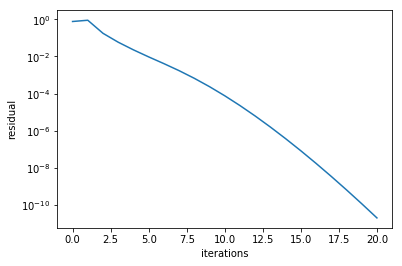

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(1)
ax1 = fig.add_subplot(111, yscale='log', xlabel='iterations', ylabel='residual')
ax1.plot(np.arange(i), picard_error)
plt.show()

Lets wrap this up with some useful functionality.

`nonlinear_conductivity` should be able to accept any conductivity law.

In [7]:
def hofmeister1999(k0, T, a):
    return k0*(298.0/T)**a

def nonlinear_conductivity(self, k0, tolerance, k_fn, *args):
    k = k0.copy()

    error = 10.0
    i = 0
    t = clock()

    while error > tolerance:
        k_last = ode.diffusivity.copy()
        ode.update_properties(k, ode.heat_sources)

        T = ode.solve()
        k = k_fn(*args)

        error = np.absolute(k - k_last).max()
        i += 1

    print "{} iterations in {} seconds".format(i, clock()-t)

In [8]:
nonlinear_conductivity(ode, k0, tolerance, hofmeister1999, k0, ode.temperature, a)

21 iterations in 4.329317 seconds


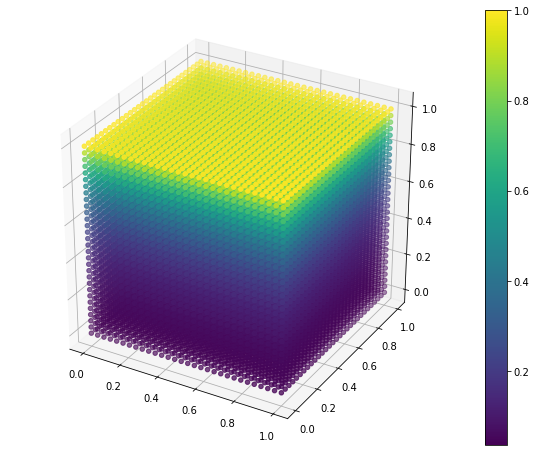

In [9]:
coords = ode.coords

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111, projection='3d')
sca = ax1.scatter3D(coords[:,0], coords[:,1], coords[:,2], c=ode.diffusivity)
fig.colorbar(sca)